# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 16.0MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Mon Feb  1 13:08:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/NLP_data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 '.ipynb_checkpoints',
 'nsmc',
 'quora']

In [7]:
# quora dir
quora_dir = os.path.join(data_dir, 'quora')
if not os.path.exists(quora_dir):
    os.makedirs(quora_dir)
os.listdir(quora_dir)

['kor_Pair_test.csv', 'kor_pair_train.csv', 'stub.csv', 'stub.hdf5']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq_1 = 26  # number of sequence 1
n_seq_2 = 27  # number of sequence 2
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [20]:
def build_model(n_vocab, d_model, n_seq_1, n_seq_2):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq_1: 문장 1 길이 (단어 수)
    :param n_seq_2: 문장 2 길이 (단어 수)
    """
    inputs_1 = tf.keras.layers.Input((n_seq_1,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((n_seq_2,))  # (bs, n_seq_2)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    ####################################
    # RNN or CNN 추가해 보세요.
    rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    hidden_1 = rnn(hidden_1)
    hidden_2 = rnn(hidden_2)

    lstm = tf.keras.layers.LSTM(units=128, return_sequences=True)
    hidden_1 = lstm(hidden_1)
    hidden_2 = lstm(hidden_2)

    gru = tf.keras.layers.GRU(units=128, return_sequences=True)
    hidden_1 = gru(hidden_1)
    hidden_2 = gru(hidden_2)

    cnn = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same')
    hidden_1 = cnn(hidden_1)
    hidden_2 = cnn(hidden_2)

    ####################################
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool_1 = pool(hidden_1)  # (bs, d_model)
    hidden_pool_2 = pool(hidden_2)  # (bs, d_model)
    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
    outputs = K.exp(-distance)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=outputs)
    return model

# All Data Project

## Data


In [11]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [12]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [13]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [14]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [15]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [16]:
def load_data(df, n_seq_1, n_seq_2):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_seq_1: number of sequence 1
    :param n_seq_2: number of sequence 2
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    inputs_1 = np.zeros((len(df), n_seq_1)).astype(np.int32)
    inputs_2 = np.zeros((len(df), n_seq_2)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        is_duplicate = row['is_duplicate']
        question1 = row['question1']
        question2 = row['question2']
        # print(is_duplicate, question1, question2)

        tokens_1 = vocab.encode_as_pieces(question1)
        # print(len(tokens_1), ':', tokens_1)
        tokens_2 = vocab.encode_as_pieces(question2)
        # print(len(tokens_2), ':', tokens_2)

        token_ids_1 = vocab.encode_as_ids(question1)
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = vocab.encode_as_ids(question2)
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 = token_ids_1[:n_seq_1]
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = token_ids_2[:n_seq_2]
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 += [0] * (n_seq_1 - len(token_ids_1))
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 += [0] * (n_seq_2 - len(token_ids_2))
        # print(len(token_ids_2), ':', token_ids_2)

        labels[index] = 1 - is_duplicate  # 0 -> 1, 1 -> 0
        inputs_1[index] = token_ids_1
        inputs_2[index] = token_ids_2
        index += 1
    return inputs_1, inputs_2, labels

In [17]:
# train data 생성
train_inputs_1, train_inputs_2, train_labels = load_data(df_train, n_seq_1, n_seq_2)
train_inputs_1, train_inputs_2, train_labels

(array([[ 3800,    26,  7314, ...,     0,     0,     0],
        [   67,    15,  8256, ...,     0,     0,     0],
        [   67,    15,    62, ...,     0,     0,     0],
        ...,
        [17834,    10,    20, ...,     0,     0,     0],
        [17834,  1151,  4468, ...,     0,     0,     0],
        [ 2067, 17548,    22, ...,     0,     0,     0]], dtype=int32),
 array([[   67,    15, 13442, ...,     0,     0,     0],
        [   67,    15,   218, ...,     0,     0,     0],
        [  242,    15,    85, ...,     0,     0,     0],
        ...,
        [ 5135, 29356,    29, ...,     0,     0,     0],
        [17834,  1151,  4468, ...,     0,     0,     0],
        [ 5135,    13, 20337, ...,     0,     0,     0]], dtype=int32),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [18]:
# test data 생성
test_inputs_1, test_inputs_2, test_labels = load_data(df_test, n_seq_1, n_seq_2)
test_inputs_1, test_inputs_2, test_labels

(array([[  513,   704,     9, ...,     0,     0,     0],
        [   36,    15,  5657, ...,     0,     0,     0],
        [   36,    15,  7314, ...,     0,     0,     0],
        ...,
        [22848, 27427,  4221, ...,     0,     0,     0],
        [10736,  2101,  2329, ...,     0,     0,     0],
        [17194,    32,  3971, ...,     0,     0,     0]], dtype=int32),
 array([[ 5775,  2184,  1973, ...,     0,     0,     0],
        [   36,    15, 10711, ...,     0,     0,     0],
        [ 1680, 29038,    36, ...,     0,     0,     0],
        ...,
        [27427,  4221,  4418, ...,     0,     0,     0],
        [22827,   141, 17629, ...,     0,     0,     0],
        [ 1001,  3971,    18, ...,     0,     0,     0]], dtype=int32),
 array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 

## 학습

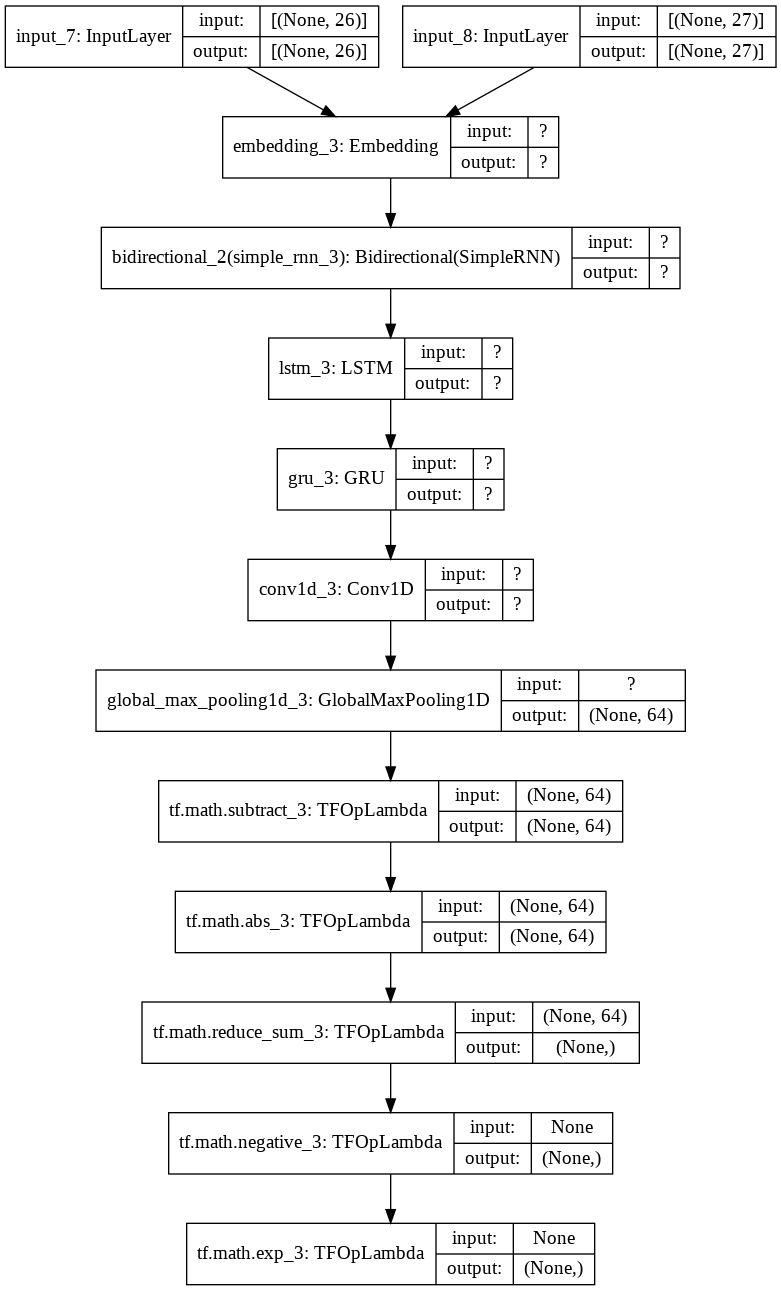

In [35]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [36]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

In [37]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(quora_dir, 'stub.hdf5'),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(quora_dir, 'stub.csv'))

In [38]:
# 모델 학습
history = model.fit((train_inputs_1, train_inputs_2),
                    train_labels,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
27/27 [==============================] - 12s 219ms/step - loss: 0.1657 - binary_accuracy: 0.7672 - val_loss: 0.2394 - val_binary_accuracy: 0.5934

Epoch 00001: val_binary_accuracy improved from -inf to 0.59339, saving model to /content/drive/MyDrive/NLP_data/quora/stub.hdf5
Epoch 2/100
27/27 [==============================] - 5s 175ms/step - loss: 0.1088 - binary_accuracy: 0.8849 - val_loss: 0.2591 - val_binary_accuracy: 0.5713

Epoch 00002: val_binary_accuracy did not improve from 0.59339
Epoch 3/100
27/27 [==============================] - 5s 173ms/step - loss: 0.0783 - binary_accuracy: 0.9185 - val_loss: 0.2360 - val_binary_accuracy: 0.6287

Epoch 00003: val_binary_accuracy improved from 0.59339 to 0.62867, saving model to /content/drive/MyDrive/NLP_data/quora/stub.hdf5
Epoch 4/100
27/27 [==============================] - 5s 168ms/step - loss: 0.0560 - binary_accuracy: 0.9498 - val_loss: 0.2459 - val_binary_accuracy: 0.6203

Epoch 00004: val_binary_accuracy did not impro

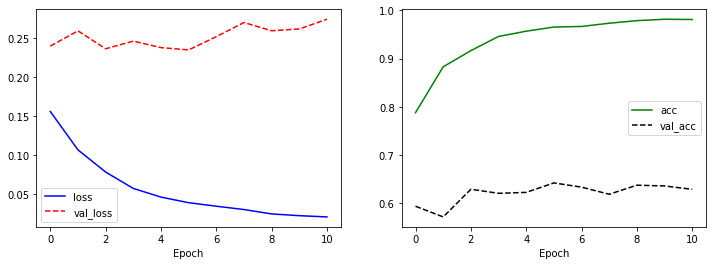

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='acc')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [40]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# train weight로 초기화
model.load_weights(os.path.join(quora_dir, 'stub.hdf5'))

In [41]:
# 예측
logits = model.predict((test_inputs_1, test_inputs_2))
logits

array([5.87283522e-02, 1.76990688e-01, 5.61442852e-01, 5.72297454e-01,
       6.56198084e-01, 5.92100492e-04, 6.03616238e-01, 4.74260211e-01,
       5.57159245e-01, 7.51758277e-01, 8.91909301e-01, 3.28755856e-01,
       7.83497036e-01, 7.22211972e-02, 6.09418936e-02, 7.55842090e-01,
       6.12104952e-01, 8.07456255e-01, 7.92287767e-01, 7.89611220e-01,
       7.97733426e-01, 5.88491499e-01, 6.86279655e-01, 7.76329875e-01,
       6.60523653e-01, 5.88887453e-01, 2.04722837e-01, 3.88829917e-01,
       6.29373848e-01, 8.98362041e-01, 1.34348627e-02, 3.25102150e-01,
       4.15539205e-01, 8.52811158e-01, 8.92537117e-01, 5.54954708e-01,
       1.57387123e-01, 5.45051813e-01, 6.61537111e-01, 8.43423605e-01,
       3.75619948e-01, 5.16357839e-01, 1.08441800e-01, 7.01854050e-01,
       1.41107077e-02, 8.63915384e-01, 1.90287545e-01, 9.72145736e-01,
       4.62729305e-01, 2.53898472e-01, 8.34641337e-01, 7.30381191e-01,
       1.07710706e-02, 5.58350742e-01, 4.44450229e-01, 7.70316541e-01,
      

In [42]:
# 0.5를 기준으로 (0, 1) 결정
test_preds = (0.5 < logits).astype(np.int)
test_preds

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [43]:
# confusion matrix 계산
confusion_matrix = np.zeros((2, 2)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[154, 175],
       [ 71, 288]])

In [44]:
# score 계산
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max(tp + fp, 1)
print(f'precision: {precision}')
recall = (tp) / max(tp + fn, 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max(precision + recall, 1)
print(f'f1: {f1}')

accuracy: 0.6424418604651163
precision: 0.6220302375809935
recall: 0.8022284122562674
f1: 0.7007299270072993


In [50]:
def do_predict(model, n_seq_1, string1, n_seq_2, string2):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq_1: 입력 개수 1
    :param string1: 입력 문자열 1
    :param n_seq_1: 입력 개수 3
    :param string2: 입력 문자열 2
    """
    # token 생성: <string 1 tokens>, [PAD] tokens
    token1 = vocab.encode_as_ids(string1)[:n_seq_1]
    token1 += [0] * (n_seq_1 - len(token1))

    # token 생성: <string 2 tokens>, [PAD] tokens
    token2 = vocab.encode_as_ids(string2)[:n_seq_2]
    token2 += [0] * (n_seq_2 - len(token2))

    y_pred = model.predict((np.array([token1]), np.array([token2])))

    # print(y_pred[0]) 예측값 확인을 위해 추가

    return "같음" if y_pred[0] > 0.5 else "다름"

In [56]:
while True:
    print("string #1 > ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("string #2 > ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    print(f"output > {do_predict(model, n_seq_1, string1, n_seq_2, string2)}")

string #1 > 헤어 에센스 냄새 별로야
string #2 > 스탠드 이케아꺼 좋더라
output > 다름
string #1 > 나 배고파
string #2 > 저녁 먹으러가자
output > 같음
string #1 > 
